In [2]:
import numpy as np
import sys
sys.path.insert(1,'../../src')
from _generate_time_series import *
from _shear_frame import *
from utils_OB import *
from _clustering import *

%load_ext autoreload
%autoreload 2

#### Setting up the initial system:

In [3]:
# stiffness and mass: 
kx=np.array([2,2,2,2])*4000
ky=kx
m=np.array([1,1,1,1])*500

#### Specify the development with time

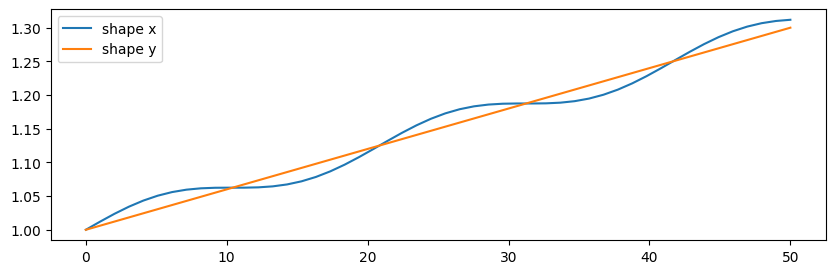

In [22]:
n=50  #number of time series to run

#shapes for how the stiffnesses should behave trougout the time series:
shapey=np.linspace(1,1.3,n)
shapex=np.sin(2*np.pi*shapey*8)*0.02+shapey

fig=plt.figure(figsize=(10,3))
plt.plot(np.linspace(0,n),shapex,label='shape x')
plt.plot(np.linspace(0,n),shapey, label='shape y')
plt.legend()
plt.show()

#### Defining the time series and modal orders

In [23]:
#What modal orders to run in the cov-ssi:
orders=np.arange(2,50,1)

#sampling frequency and lengt of each time series:
fs=7        #Hz
T_max=3000  #sec
t=np.arange(0,T_max,1/fs)

#### Specifing the load
        If none of [next_segment,next_DOF,harmonic,harmonic_part] is 
        specified the same white noise loading are used for all
        DOFs, for all the time series.  
        
        next_segment: 'new' or'same'
                whether or not to creata a new set of loads 
                for each time segment
                
        next_DOF: 'new','same' or 'random'
                whether or not to create a new set of loading for each
                DOF. 'same' uses the same load series, new creates a new
                series with same parameters, randaom creates random params.
                as well.
        white_noise_amp: float
                the relative amplitude of the white noise 

        harmonic: string or None
            'random' crates a random freq. in the interval [0.5w_0,2w_n] w 
            are natural frqs of the frame.
            'decreasing' creates a decreasing frequenzy from [w_n , w_0]

        harmonic_part: float
            the harmonic amplitude in relation to the white noise. 0.5
            gives 50% of the amplitude.

In [24]:
# specify parameters for the load series: 
    # the general input for the amplutide of the white noise
white_noise_amp=1
    # whether or not to create new load series for each time segment
next_segment='new'
    #whether or not to greate indeviduel loadings for all DOFS
next_DOF='new'
    #Whether or not to include a harmonic part in the loading, and what type of 
    #harmonic function
harmonic=None
    #the the factor the amplitude of the harmonic is multiplied with 
    #the amplitude of the white noise
harmonic_part=0.2

### Noise fac for added measurments noice: 
noise_fac=1

## Generating the time series

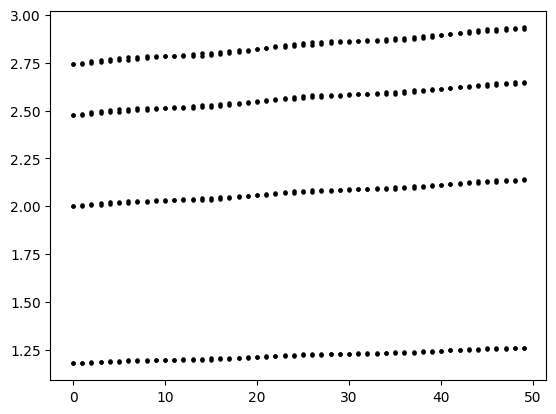

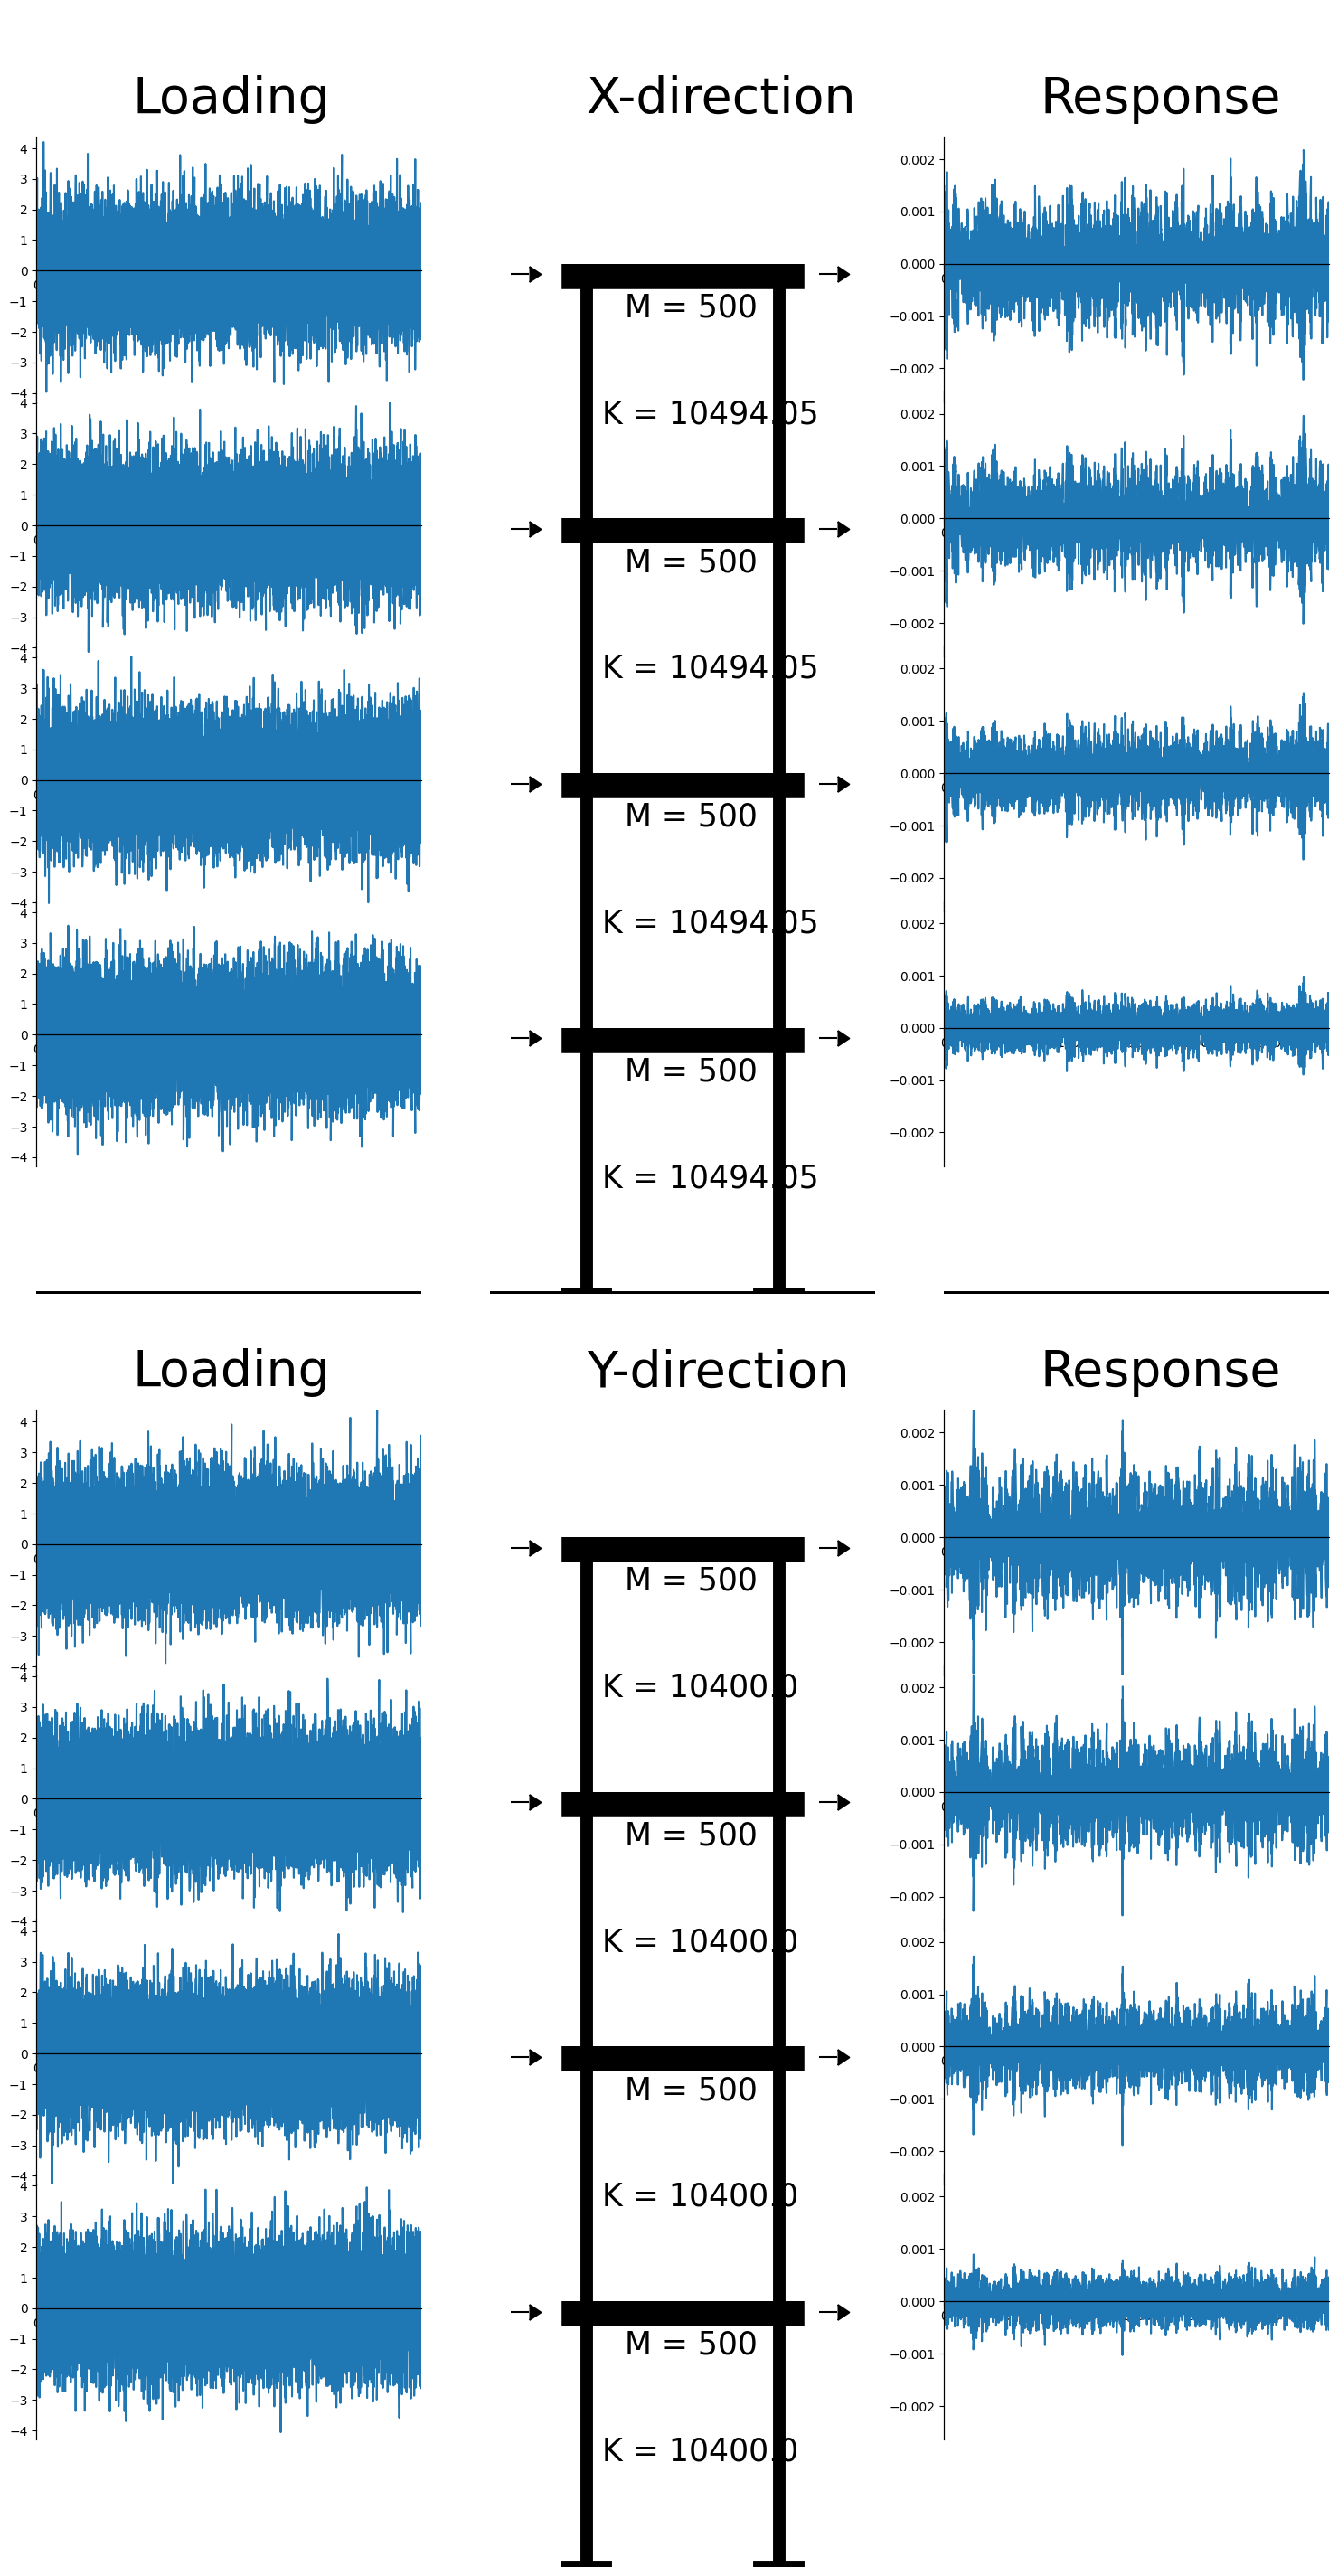

In [25]:
true_w,_,responses=generate_dynamic_series(kx,ky,shapex,shapey,m,t,
                                           white_noise_amp=white_noise_amp
                                           ,next_segment=next_segment
                                           ,next_DOF=next_DOF
                                           ,harmonic=harmonic
                                           ,harmonic_part=harmonic_part
                                           ,plot=True)

#### Running cov-ssi:

In [26]:
lambds,phis=create_input_COVssi(responses,t,orders)

#### Plotting each time segment as a column

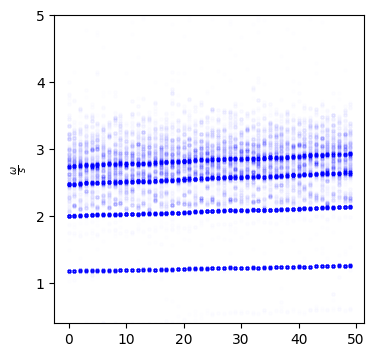

In [27]:
matplotlib.use('module://matplotlib_inline.backend_inline') #setting backend in case cells are not run in appropriate order
ys=create_output_guassian(lambds)

til_jon=ys.T

plt.figure(figsize=(4,4))
for k,s in enumerate(ys): 
    plt.scatter(s*0+k,s,s=6,alpha=0.005,color='blue')
plt.ylim(0.4,5)
plt.ylabel(r"$\frac{\omega}{s}$")
plt.show()

# plt.figure(figsize=(10,10))
# for k,s in enumerate(ys): 
#     plt.scatter(s*0+k,s,s=6,alpha=0.02,color='blue')
#     plt.scatter(true_w[k]*0+k,true_w[k],color='black',marker=1)
# plt.ylim(0.4,3.6)

#### Setting the parameters for the clustering

In [28]:
valid_range= { 'freq': [1e-4, np.inf],'damping': [1e-4,np.inf] }

indicator='freq'
s=1
stabcrit = {'freq':0.05, 'damping': 0.1, 'mac': 0.1}
prob_threshold = 0.5   #probability of pole to belong to 
# cluster, based on estimated "probability" density function

min_cluster_size=20 
min_samples=10
scaling={'mac':1.0, 'lambda_real':1.0, 'lambda_imag': 1.0}


#### Clustering: 

In [29]:
phis_out,lambds_out=clustering(lambds,
phis,orders,s,stabcrit,valid_range,indicator,prob_threshold,
scaling,min_cluster_size,min_samples,true_w=true_w,plot=False)

#### Plotting the output, aka the test case:

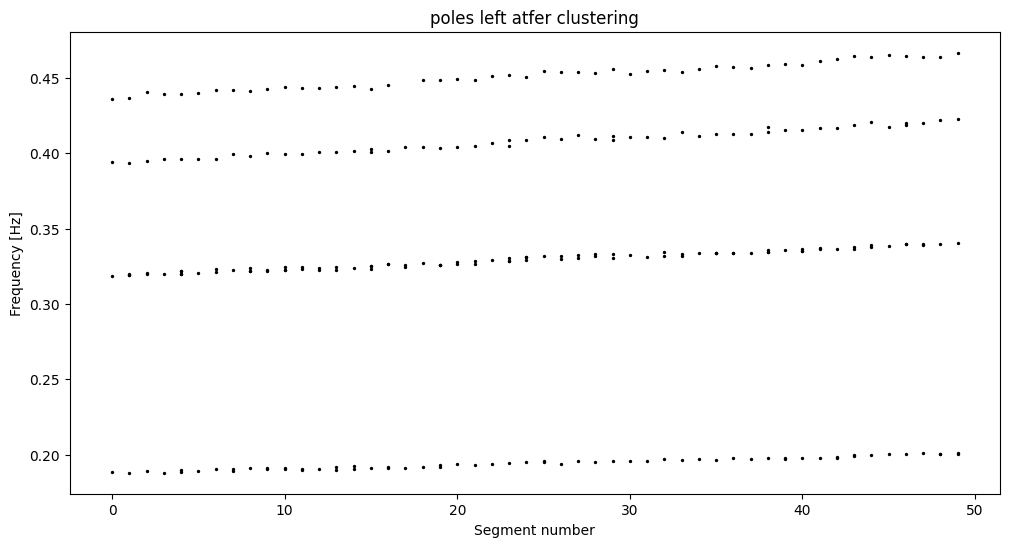

In [32]:
matplotlib.use('module://matplotlib_inline.backend_inline') #setting backend in case cells are not run in appropriate order

fig,ax =plt.subplots(figsize=(12,6))
for segment_number,lambd_i in enumerate(lambds_out):
    ax.scatter(np.ones_like(lambd_i)*segment_number,
               np.abs(lambd_i)**0.5/2/np.pi,color='black',s=2)
    ax.set_title('poles left atfer clustering')
    ax.set_xlabel('Segment number')
    ax.set_ylabel('Frequency [Hz]')
plt.show()

In [31]:
np.savez('test_2',np.array(lambds_out,dtype=object),
         np.array(phis_out,dtype=object))